In [33]:
import sys
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def write_to_json(output, file_id=''):
    if isinstance(output, pd.DataFrame):
        data = json.loads(output.to_json(default_handler=str, orient='records'))
    elif isinstance(output, pd.Series):
        data = output.to_dict()
    else:
        data = output
    with open(f'result/output_{file_id}.json', 'w', encoding='utf-8') as file:
        json.dump(data, file, indent=4)

def analyze_memory_usage(file_path=None, variable=None):
    output = {
        'file_size': None,
        'variable_memory_usage': None
    }
    if file_path is not None:
        output['file_size'] = os.path.getsize(file_path)
    if variable is not None:
        output['variable_memory_usage'] = sys.getsizeof(variable)
    return output

def read_file(file_path):
    return pd.read_csv(file_path)

def get_memory_usage(pd_obj):
    if isinstance(pd_obj, pd.DataFrame):
        usage_b = pd_obj.memory_usage(deep=True).sum()
    else:
        usage_b = pd_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2
    return {'memory_usage': "{:03.2f} MB".format(usage_mb)}

def get_memory_usage_by_column(pd_obj):
    memory_usage_stat = pd_obj.memory_usage(deep=True)
    total_memory_usage =  memory_usage_stat.sum()
    print(f'total_memory_usage: {total_memory_usage // 1024:10} kb')
    column_usage = []
    for key in pd_obj.dtypes.keys():
        column_usage.append({
            'column_name': key,
            'memory_abs': memory_usage_stat[key] // 1024,
            'memory_per': round(memory_usage_stat[key] / total_memory_usage * 100, 4),
            'dtype': pd_obj.dtypes[key]
        })
    column_usage.sort(key= lambda x: x['memory_abs'], reverse=True)
    output_df = pd.DataFrame()
    for column in column_usage:
        output_df = pd.concat([output_df, pd.DataFrame([column])], ignore_index = True)
        print(f'{column['column_name']:30}: {column['memory_abs']: 10} KB: {column['memory_per']:10}% : {column['dtype']}')
    return output_df

def opt_obj(df):
    converted_obj = pd.DataFrame()
    dataset_obj = df.select_dtypes(include=['object']).copy()

    for col in dataset_obj.columns:
        num_unique_values = len(dataset_obj[col].unique())
        num_total_values = len(dataset_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:, col] = dataset_obj[col].astype('category')
    
    print(get_memory_usage(dataset_obj))
    print(get_memory_usage(converted_obj))
    return converted_obj

def opt_int(df):
    dataset_int = df.select_dtypes(include=['int'])
    converted_int = dataset_int.apply(pd.to_numeric, downcast='unsigned')
    print(get_memory_usage(dataset_int))
    print(get_memory_usage(converted_int))
    return converted_int

def opt_float(df):
    dataset_float = df.select_dtypes(include=['float'])
    converted_flt = dataset_float.apply(pd.to_numeric, downcast='float')
    print(get_memory_usage(dataset_float))
    print(get_memory_usage(converted_flt))
    return converted_flt

def read_types(file_path):
    dtypes = {}
    with open(file_path, 'r') as file:
        dtypes = json.load(file)

    for key in dtypes.keys():
        if dtypes[key] == 'category':
            dtypes[key] = pd.CategoricalDtype
        elif dtypes[key] == 'string':
            dtypes[key] = pd.StringDtype
        else:
            dtypes[key] = np.dtype(dtypes[key])
    
    return dtypes

In [2]:
file_path = 'data/vehicles.csv'
df = read_file(file_path)

In [53]:
write_to_json(analyze_memory_usage(df), 'analyze_memory_usage')
write_to_json(get_memory_usage_by_column(df), 'memory_usage_by_column_without_opt')

total_memory_usage:    4357860 kb
description                   :    3865695 KB:    88.7063% : object
url                           :      57555 KB:     1.3207% : object
image_url                     :      48311 KB:     1.1086% : object
region_url                    :      33383 KB:     0.7661% : object
posting_date                  :      30429 KB:     0.6983% : object
model                         :      25249 KB:     0.5794% : object
region                        :      25197 KB:     0.5782% : object
transmission                  :      23795 KB:      0.546% : object
manufacturer                  :      22449 KB:     0.5152% : object
title_status                  :      22356 KB:      0.513% : object
VIN                           :      22159 KB:     0.5085% : object
fuel                          :      21790 KB:        0.5% : object
state                         :      21260 KB:     0.4879% : object
type                          :      20515 KB:     0.4708% : object
cylinders     

In [7]:
converted_obj = opt_obj(df)
converted_int = opt_int(df)
converted_flt = opt_float(df)

{'memory_usage': '4233.87 MB'}
{'memory_usage': '23.00 MB'}
{'memory_usage': '6.51 MB'}
{'memory_usage': '4.89 MB'}
{'memory_usage': '16.28 MB'}
{'memory_usage': '8.14 MB'}


In [8]:
optimized_df = df.copy()

In [9]:
optimized_df[converted_obj.columns] = converted_obj
optimized_df[converted_int.columns] = converted_int
optimized_df[converted_flt.columns] = converted_flt

In [10]:
write_to_json(get_memory_usage_by_column(optimized_df), 'memory_usage_by_column_with_opt')

total_memory_usage:    4039852 kb
description                   :    3866665 KB:     95.713% : object
url                           :      57555 KB:     1.4247% : object
image_url                     :      48311 KB:     1.1959% : object
posting_date                  :      30429 KB:     0.7532% : object
VIN                           :      13412 KB:      0.332% : category
model                         :       3783 KB:     0.0937% : category
id                            :       3335 KB:     0.0826% : uint64
price                         :       1667 KB:     0.0413% : uint32
year                          :       1667 KB:     0.0413% : float32
odometer                      :       1667 KB:     0.0413% : float32
county                        :       1667 KB:     0.0413% : float32
lat                           :       1667 KB:     0.0413% : float32
long                          :       1667 KB:     0.0413% : float32
region_url                    :        882 KB:     0.0218% : category
reg

In [29]:
need_dtypes = read_types('data/output_dtypes_10.json')

In [30]:
dataset = pd.read_csv('data/vehicles.csv', usecols=lambda x: x in need_dtypes.keys(), dtype=need_dtypes)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_13848\3473127866.py:1: UserWarning: Instantiating CategoricalDtype without any arguments.Pass a CategoricalDtype instance to silence this warning.
  dataset = pd.read_csv('data/vehicles.csv', usecols=lambda x: x in need_dtypes.keys(), dtype=need_dtypes)
C:\Users\Администратор\AppData\Local\Temp\ipykernel_13848\3473127866.py:1: UserWarning: Instantiating CategoricalDtype without any arguments.Pass a CategoricalDtype instance to silence this warning.
  dataset = pd.read_csv('data/vehicles.csv', usecols=lambda x: x in need_dtypes.keys(), dtype=need_dtypes)


In [31]:
dataset.to_csv('data/vehicles_short.csv')

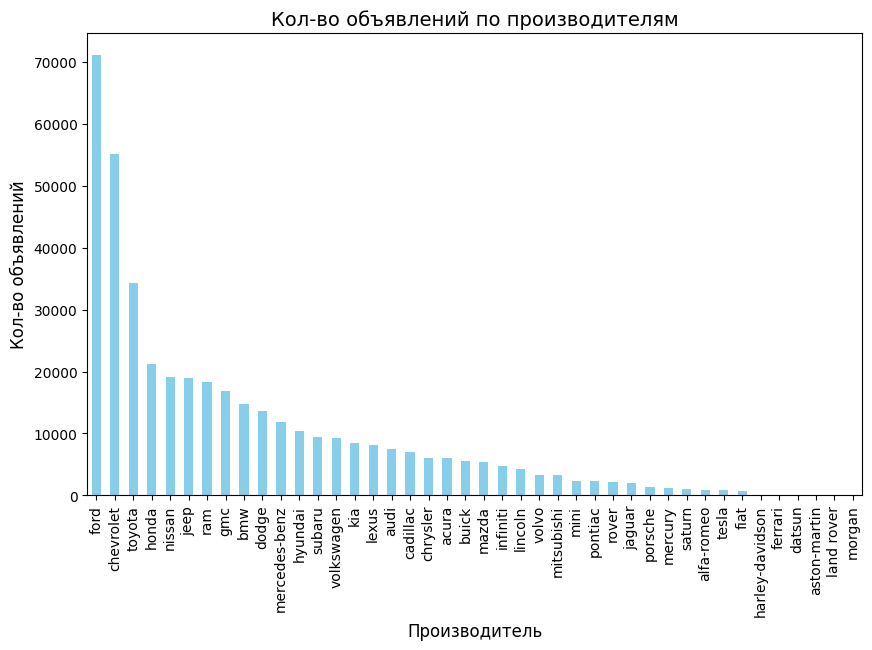

In [43]:
# Кол-во объявлений по производителям
manufacturer_counts = df['manufacturer'].value_counts()

plt.figure(figsize=(10, 6))
manufacturer_counts.plot(kind='bar', color='skyblue')
plt.title('Кол-во объявлений по производителям', fontsize=14)
plt.xlabel('Производитель', fontsize=12)
plt.ylabel('Кол-во объявлений', fontsize=12)
plt.xticks(rotation=90)
plt.show()

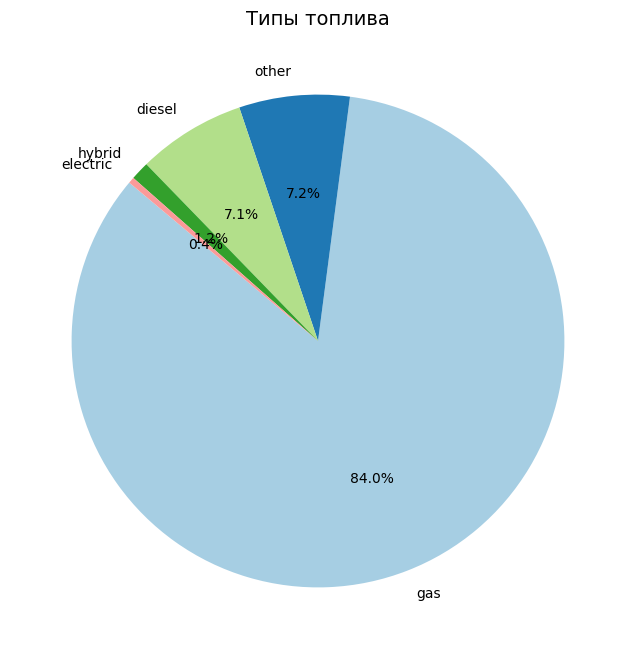

In [44]:
# Диаграмма по типу топлива
fuel_counts = df['fuel'].value_counts()

plt.figure(figsize=(8, 8))
fuel_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Типы топлива', fontsize=14)
plt.ylabel('')
plt.show()

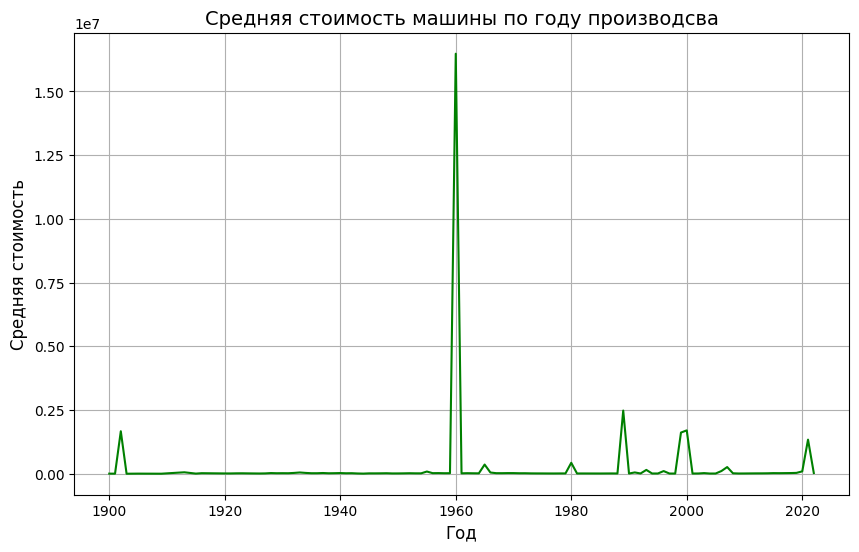

In [46]:
# Средняя стоимость машины по году производсва
average_price_by_year = df.groupby('year')['price'].mean()

plt.figure(figsize=(10, 6))
average_price_by_year.plot(kind='line', color='green')
plt.title('Средняя стоимость машины по году производсва', fontsize=14)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Средняя стоимость', fontsize=12)
plt.grid()
plt.show()

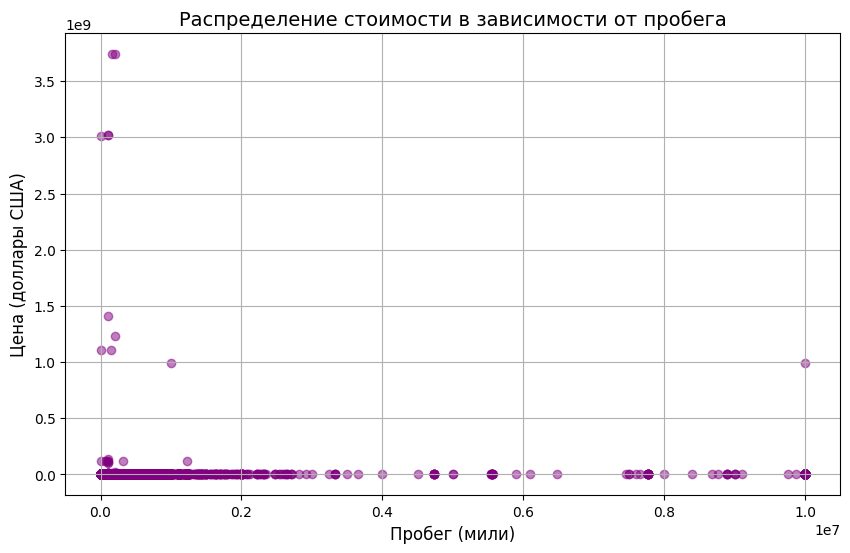

In [47]:
# Распределение стоимости в зависимости от пробега
plt.figure(figsize=(10, 6))
plt.scatter(df['odometer'], df['price'], alpha=0.5, color='purple')
plt.title('Распределение стоимости в зависимости от пробега', fontsize=14)
plt.xlabel('Пробег (мили)', fontsize=12)
plt.ylabel('Цена (доллары США)', fontsize=12)
plt.grid()
plt.show()

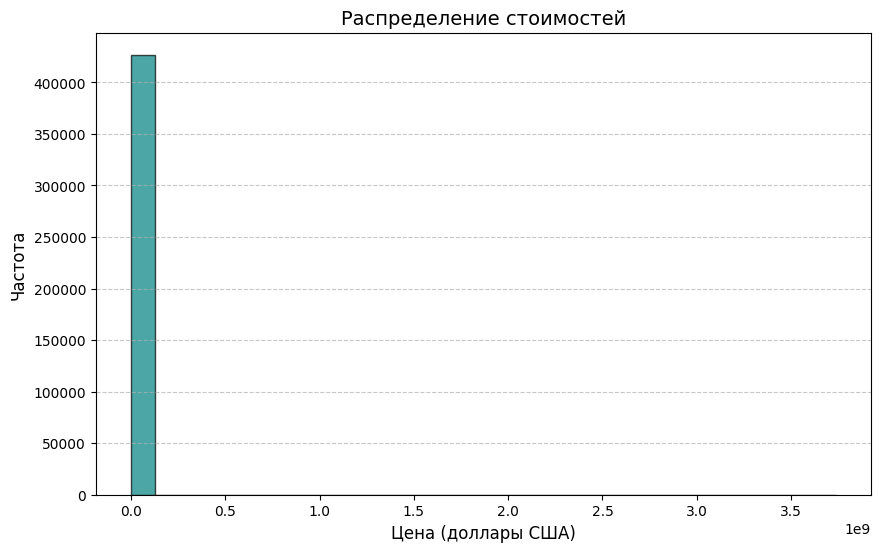

In [48]:
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=30, color='teal', edgecolor='black', alpha=0.7)
plt.title('Распределение стоимостей', fontsize=14)
plt.xlabel('Цена (доллары США)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()